In [3]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipynb
from scipy.spatial import distance_matrix
import random
import sys as sys
import time
import re
import pickle
import math

In [4]:
from ipynb.fs.full.datamanagement import user_filter, summarise_listening_history
from ipynb.fs.full.evaluation_workflow import split_history
from ipynb.fs.full.feature_based_algos import get_listenings_history_partition, kmeans_based_ranking, rank_by_artist_filter


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, auc

from scipy.spatial import distance_matrix

## Data loading

In [37]:
# Read the data
CUR_DIR = os.path.abspath('')

DATA_DIR = Path(CUR_DIR).parent / "data"
FIG_PATH = Path(CUR_DIR).parent/'figures'

FILE_PATH = DATA_DIR/'triplets_metadata_spotify.csv'
df = pd.read_csv(FILE_PATH, index_col = 0)

In [6]:
df['track_id'] = df.song_name + ' - ' + df.artist_name

In [7]:
len(df)

4982520

## Data management

In [8]:
## keep first occurence of a given song/artist instance to reduce redundant observations

df = df.drop_duplicates(subset = ['user','track_id'], keep='first')
len(df)

4973744

In [9]:
df.columns

Index(['user', 'listening_count', 'song_name', 'release', 'artist_name',
       'duration', 'artist_familiarity', 'artist_hotttnesss', 'year',
       'shs_perf', 'shs_work', 'explicit', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'release_date',
       'track_id'],
      dtype='object')

### Users filtering

In [10]:
users_summary = summarise_listening_history(df)

In [11]:
ids = user_filter(users_summary, nlist_min = 1, nlist_max = 500, ntracks_min = 5)

In [12]:
wdf = df.loc[df['user'].isin(ids),:]
wdf_users_summary = users_summary.loc[users_summary['user'].isin(ids),:]

In [13]:
print('Nb of ligns in df  :', len(df))
print('Nb of ligns in wdf :', len(wdf))

Nb of ligns in df  : 4973744
Nb of ligns in wdf : 3856377


In [14]:
len(wdf_users_summary)

327081

### Songs management

In [15]:
# Get the songs quantitative features

tracks_feats = df.drop(['user', 'listening_count'],axis = 1)
tracks_feats['track_id'] = df.song_name + ' - ' + df.artist_name
tracks_quanti_feats = tracks_feats.drop(['song_name', 'release', 'artist_name',
        'artist_familiarity', 'artist_hotttnesss', 'year', 'key',
       'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date', 'duration', 'tempo'], axis = 1).drop_duplicates()

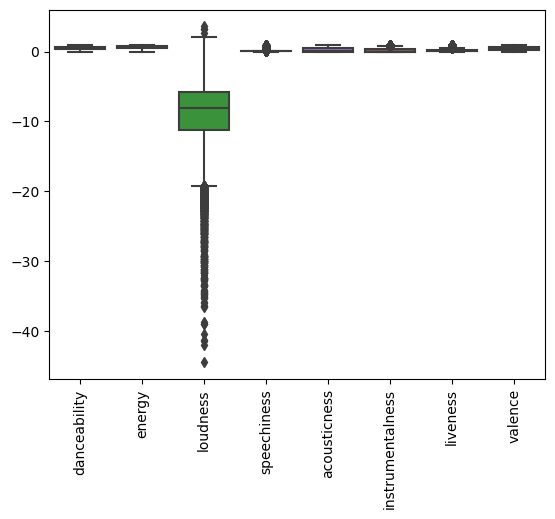

In [35]:
ax = sns.boxplot(tracks_quanti_feats)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
plt.show()

In [16]:
# Normalize the songs quantitative feats
X = tracks_quanti_feats.drop(['track_id'], axis = 1)
X.index = tracks_quanti_feats.track_id

scaler = StandardScaler()
X[X.columns] = pd.DataFrame(scaler.fit_transform(X), index=X.index)


In [17]:
X

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
track_id,,,,,,,,
Stronger - Kanye West,0.667073,0.244482,0.234685,0.971940,-0.825165,-0.623569,1.661334,0.055057
Stacked Actors - Foo Fighters,-0.048441,1.150060,0.862181,-0.294877,-0.842482,-0.620462,0.105924,0.728483
Clarity - John Mayer,0.868312,0.283685,1.220943,-0.411504,-0.316887,-0.526080,-0.197701,0.039664
Gimme Stitches - Foo Fighters,0.180747,1.244146,1.071496,-0.108876,-0.843348,-0.614856,0.260399,0.197438
Breakout - Foo Fighters,-0.501227,1.165741,1.072171,-0.272758,-0.848599,-0.614704,-0.480018,-0.206617
...,...,...,...,...,...,...,...,...
Dime - Jerry Rivera,0.991291,-0.429800,-0.219056,-0.392401,1.575591,-0.623569,0.015369,1.247983
The Long Conversation - Pierre de Reeder,-0.395018,-1.370660,-0.236161,-0.523105,1.705467,-0.520901,0.825034,-1.007032
That's the Way That It Was - Pierre de Reeder,0.583224,0.228801,0.703957,-0.425580,-0.754445,-0.623329,-0.543939,-0.679940


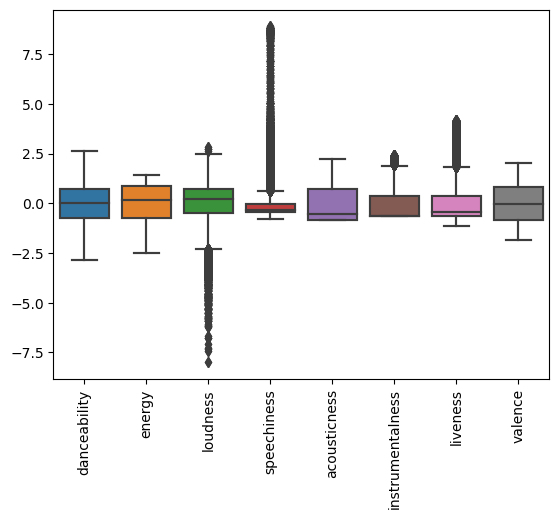

In [38]:
ax = sns.boxplot(X)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
plt.savefig(FIG_PATH/f'Data_viz/audio_features_boxplot.jpg')
plt.show()

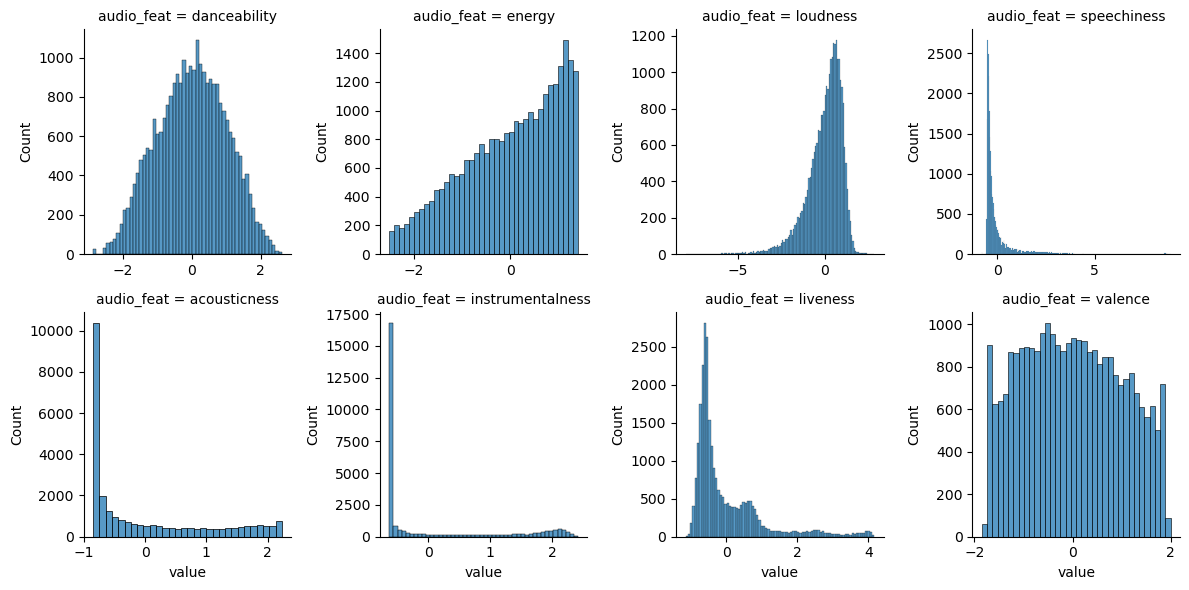

In [49]:
g = sns.FacetGrid(X.melt(var_name = 'audio_feat', value_name = 'value'), col = 'audio_feat', col_wrap = 4, sharey = False, sharex = False)
g.map(sns.histplot, 'value')
plt.savefig(FIG_PATH/f'Data_viz/audio_features_distribution.jpg')
plt.show()

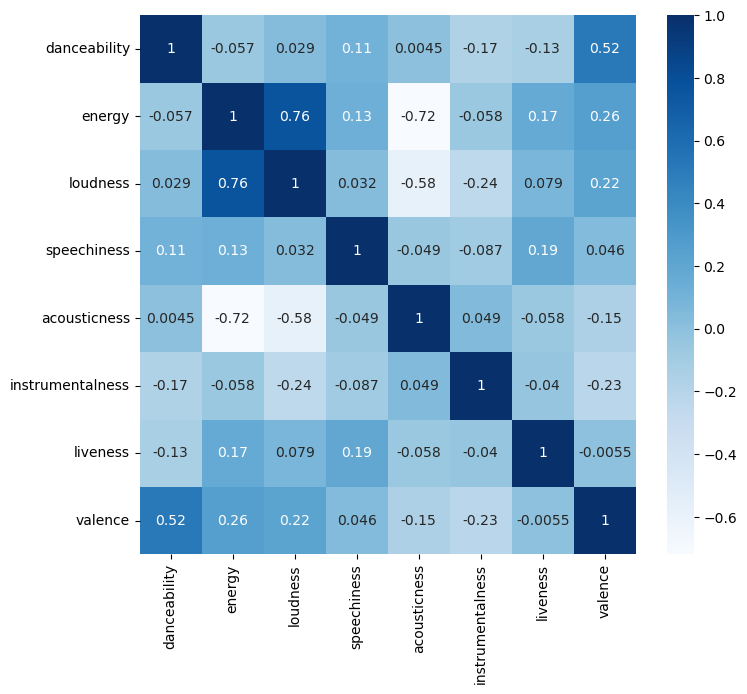

In [55]:
corr = X.corr()
plt.figure(figsize =(8,7))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.savefig(FIG_PATH/f'Data_viz/audio_features_corr_tracks.jpg')
plt.show()

## Recommendation algorithms evaluation

In [13]:
wdf_sorted = wdf.sort_values('user')
wdf_users_summary_sorted = wdf_users_summary.sort_values('user')

In [14]:
# Set the seed
seed = 1234
random.seed(seed)

In [21]:
# # Try 1; Triplets non sorted by users, without users_summary
# st = time.time()
# test1, test2 = split_history(wdf, 0.2, sort = True, random_state = seed)
# et = time.time()
# elapsed_time = et - st
# print('Execution time 1:', elapsed_time, 'seconds')

Sorting the triplets by users id ... Done
Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...Execution time 1: 42.95786738395691 seconds


In [22]:
# # Try 2: Triplets non sorted by users, with users_summary
# st = time.time()
# test1, test2 = split_history(wdf, 0.2, sort = True, users_summary = wdf_users_summary, random_state = seed)
# et = time.time()
# elapsed_time = et - st
# print('Execution time 2:', elapsed_time, 'seconds')

Sorting the triplets by users id ... Done
Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...Execution time 2: 36.215386390686035 seconds


In [23]:
# # Try 3: Triplets sorted by users, without users_summary
# st = time.time()
# test1, test2 = split_history(wdf_sorted, 0.2, sort = False, random_state = seed)
# et = time.time()
# elapsed_time = et - st
# print('Execution time 3:', elapsed_time, 'seconds')


Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...Execution time 2: 21.979166746139526 seconds


In [21]:
# # Try 4: Triplets sorted by users, with users_summary
# st = time.time()
# test1, test2 = split_history(wdf_sorted, 0.2, sort = False, users_summary = wdf_users_summary_sorted, random_state = seed)
# et = time.time()
# elapsed_time = et - st
# print('\n')
# print(f'Execution time 4: {round(elapsed_time,3)}seconds')


Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...

Execution time 4: 6.762seconds


In [16]:
RES_FOLDNAME = 'results/'+str(seed)
RES_FOLD = DATA_DIR/RES_FOLDNAME
# os.mkdir(RES_FOLD)


In [54]:
## Save the apparent and hidden playlist

# data_set = {
#         'apparent' : test1,
#         'hidden' : test2
#     }
# with open(RES_FOLD/'data_set.pickle', 'wb') as fp:
#     pickle.dump(data_set, fp)

In [24]:
with open(RES_FOLD/'data_set.pickle', 'rb') as fp:
    data_set = pickle.load(fp)

### Initialization of the ranking saving files

In [55]:

# random_ranking = {}
# avg_ranking = {}
# kmbr_ranking = {}
# avg_af_ranking = {}
# kmbr_af_ranking = {}

# with open(RES_FOLD/'random_ranking.pickle', 'wb') as fp:
#     pickle.dump(random_ranking, fp)

# with open(RES_FOLD/'avg_ranking.pickle', 'wb') as fp:
#     pickle.dump(avg_ranking, fp)

# with open(RES_FOLD/'kmbr_ranking.pickle', 'wb') as fp:
#     pickle.dump(kmbr_ranking, fp)

# with open(RES_FOLD/'avg_af_ranking.pickle', 'wb') as fp:
#     pickle.dump(avg_af_ranking, fp)

# with open(RES_FOLD/'kmbr_af_ranking.pickle', 'wb') as fp:
#     pickle.dump(kmbr_af_ranking, fp)


In [56]:
# # Initialization of the algorithm performance evaluation files
# random_perf = {
#             'tpr' : {},
#             'fpr' : {}
#         }
# avg_perf = {
#             'tpr' : {},
#             'fpr' : {}
#         }
# kmbr_perf = {
#             'tpr' : {},
#             'fpr' : {}
#         }
# avg_af_perf = {
#             'tpr' : {},
#             'fpr' : {}
#         }
# kmbr_af_perf = {
#             'tpr' : {},
#             'fpr' : {}
#         }

# with open(RES_FOLD/'random_perf.pickle', 'wb') as fp:
#     pickle.dump(random_perf, fp)

# with open(RES_FOLD/'avg_perf.pickle', 'wb') as fp:
#     pickle.dump(avg_perf, fp)

# with open(RES_FOLD/'kmbr_perf.pickle', 'wb') as fp:
#     pickle.dump(kmbr_perf, fp)

# with open(RES_FOLD/'avg_af_perf.pickle', 'wb') as fp:
#     pickle.dump(avg_af_perf, fp)

# with open(RES_FOLD/'kmbr_af_perf.pickle', 'wb') as fp:
#     pickle.dump(kmbr_af_perf, fp)

### Loading the previous saved results

In [9]:
with open(RES_FOLD/'random_ranking.pickle', 'rb') as fp:
    random_ranking = pickle.load(fp)

with open(RES_FOLD/'avg_ranking.pickle', 'rb') as fp:
    avg_ranking = pickle.load(fp)

with open(RES_FOLD/'kmbr_ranking.pickle', 'rb') as fp:
    kmbr_ranking = pickle.load(fp)

with open(RES_FOLD/'avg_af_ranking.pickle', 'rb') as fp:
    avg_af_ranking = pickle.load(fp)

with open(RES_FOLD/'kmbr_af_ranking.pickle', 'rb') as fp:
    kmbr_af_ranking = pickle.load(fp)


In [17]:
with open(RES_FOLD/'random_perf.pickle', 'rb') as fp:
    random_perf = pickle.load(fp)

with open(RES_FOLD/'avg_perf.pickle', 'rb') as fp:
    avg_perf = pickle.load(fp)

with open(RES_FOLD/'kmbr_perf.pickle', 'rb') as fp:
    kmbr_perf = pickle.load(fp)

with open(RES_FOLD/'avg_af_perf.pickle', 'rb') as fp:
    avg_af_perf = pickle.load(fp)

with open(RES_FOLD/'kmbr_af_perf.pickle', 'rb') as fp:
    kmbr_af_perf = pickle.load(fp)

### Hyper-parameters tuning

In [18]:
# Define the desired sample
n_tracks_min = 100
n_tracks_max = math.inf

In [21]:
ech = user_filter(wdf_users_summary, ntracks_min = n_tracks_min, ntracks_max = n_tracks_max)
sample = ech.sample(min(200,len(ech)), random_state = 1234)

In [22]:
len(sample)

327081

### Get the sample apparent and hidden playlists

In [25]:
df_apparent_sample = data_set['apparent'].loc[data_set['apparent'].user.isin(sample),: ]
df_hidden_sample =  data_set['hidden'].loc[data_set['hidden'].user.isin(sample),: ]

In [76]:
dic_hidden = { u : df_hidden_sample[['user','track_id']].loc[df_hidden_sample.user == u] for u in sample}
dic_apparent = { u : df_apparent_sample.loc[df_apparent_sample.user == u] for u in sample}

### Ranking

In [202]:
# Random ranking
dic_hidden_random_ranks = {u : random.sample(list(np.arange(1,len(X)-len(dic_hidden[u]))),len(dic_hidden[u])) for u in sample}

In [203]:
random_ranking.update(dic_hidden_random_ranks)

In [204]:
# Average-based ranking
dic_avg_ranks = {u : kmeans_based_ranking(
    listenings_history = df_apparent_sample.loc[df_apparent_sample.user == u],
    X = X,
    n_clusters = 1,
    random_state = seed) for u in sample}

In [205]:
avg_ranking.update(dic_avg_ranks)

In [206]:
# Kmeans-based ranking
dic_kmbr_ranks = {u : kmeans_based_ranking(
    listenings_history = df_apparent_sample.loc[df_apparent_sample.user == u],
    X = X,
    random_state = seed) for u in sample}

In [207]:
kmbr_ranking.update(dic_kmbr_ranks)

In [208]:
# Average-based artist-filtered ranking
dic_artist_filtered = {u : rank_by_artist_filter(initial_ranking = dic_avg_ranks[u].reset_index(), apparent_history = dic_apparent[u]) for u in sample}

In [209]:
avg_af_ranking.update(dic_artist_filtered)

In [210]:
# Kmeans-based artist-filtered ranking 
dic_kmbr_af = {u : rank_by_artist_filter(initial_ranking = dic_kmbr_ranks[u].reset_index(), apparent_history = dic_apparent[u]) for u in sample}

In [211]:
kmbr_af_ranking.update(dic_kmbr_af)

In [212]:
# Saving the ranking
with open(RES_FOLD/'random_ranking.pickle', 'wb') as fp:
    pickle.dump(random_ranking, fp)

with open(RES_FOLD/'avg_ranking.pickle', 'wb') as fp:
    pickle.dump(avg_ranking, fp)

with open(RES_FOLD/'kmbr_ranking.pickle', 'wb') as fp:
    pickle.dump(kmbr_ranking, fp)

with open(RES_FOLD/'avg_af_ranking.pickle', 'wb') as fp:
    pickle.dump(avg_af_ranking, fp)

with open(RES_FOLD/'kmbr_af_ranking.pickle', 'wb') as fp:
    pickle.dump(kmbr_af_ranking, fp)


### Evaluation of the algorithm

In [74]:
### Cutoff thresholds grid
threshold_grid = np.arange(1, len(X)+9, 10)

In [75]:
# Random ranking

rand_tpr = {u : [sum(dic_hidden_random_ranks[u] <= i)/len(dic_hidden_random_ranks[u]) for i in threshold_grid] for u in sample}
rand_fpr = {u : [(i-sum(dic_hidden_random_ranks[u] <= i))/(len(X)-len(dic_hidden_random_ranks[u])) for i in threshold_grid] for u in sample}


NameError: name 'dic_hidden_random_ranks' is not defined

In [215]:
# Average-based ranking

dic_hidden_avg_ranks = {u : list(dic_avg_ranks[u].loc[list(dic_hidden[u].track_id)].min(axis = 1)) for u in sample}
avg_tpr = {u :[sum(dic_hidden_avg_ranks[u] <= i)/len(dic_hidden_avg_ranks[u]) for i in threshold_grid ] for u in sample}
avg_fpr = {u :[(i-sum(dic_hidden_avg_ranks[u] <= i))/(len(X)-len(dic_hidden_avg_ranks[u])) for i in threshold_grid] for u in sample}

In [216]:
# Kmeans-based ranking

dic_hidden_kmbr_ranks = {u : list(dic_kmbr_ranks[u].loc[list(dic_hidden[u].track_id)].min(axis = 1)) for u in sample}
kmbr_tpr =  {u :[sum(dic_hidden_kmbr_ranks[u] <= i)/len(dic_hidden_kmbr_ranks[u]) for i in threshold_grid] for u in sample}
kmbr_fpr =  {u :[(i-sum(dic_hidden_kmbr_ranks[u] <= i))/(len(X)-len(dic_hidden_kmbr_ranks[u])) for i in threshold_grid] for u in sample}

In [217]:
# Average-based artist-filtered ranking

dic_hidden_artist_filtered_ranks = {u : list(dic_artist_filtered[u].loc[list(dic_hidden[u].track_id)].best_rank) for u in sample}
af_tpr = {u :[sum(dic_hidden_artist_filtered_ranks[u] <= i)/len(dic_hidden_artist_filtered_ranks[u]) for i in threshold_grid] for u in sample}
af_fpr = {u :[(i-sum(dic_hidden_artist_filtered_ranks[u] <= i))/(len(X)-len(dic_hidden_artist_filtered_ranks[u])) for i in threshold_grid] for u in sample}

In [218]:
# Kmeans-based artist-filtered ranking 

dic_hidden_kmbr_af_ranks = {u : list(dic_kmbr_af[u].loc[list(dic_hidden[u].track_id)].best_rank) for u in sample}
kmbr_af_tpr = {u :[sum(dic_hidden_kmbr_af_ranks[u] <= i)/len(dic_hidden_kmbr_af_ranks[u]) for i in threshold_grid] for u in sample}
kmbr_af_fpr = {u :[(i-sum(dic_hidden_kmbr_af_ranks[u] <= i))/(len(X)-len(dic_hidden_kmbr_af_ranks[u])) for i in threshold_grid] for u in sample}

In [219]:
# Saving the results

random_perf['tpr'].update(rand_tpr)
random_perf['fpr'].update(rand_fpr)

avg_perf['tpr'].update(avg_tpr)
avg_perf['fpr'].update(avg_fpr)

kmbr_perf['tpr'].update(kmbr_tpr)
kmbr_perf['fpr'].update(kmbr_fpr)

avg_af_perf['tpr'].update(af_tpr)
avg_af_perf['fpr'].update(af_fpr)

kmbr_af_perf['tpr'].update(kmbr_af_tpr)
kmbr_af_perf['fpr'].update(kmbr_af_fpr)

In [220]:
with open(RES_FOLD/'random_perf.pickle', 'wb') as fp:
    pickle.dump(random_perf, fp)

with open(RES_FOLD/'avg_perf.pickle', 'wb') as fp:
    pickle.dump(avg_perf, fp)

with open(RES_FOLD/'kmbr_perf.pickle', 'wb') as fp:
    pickle.dump(kmbr_perf, fp)

with open(RES_FOLD/'avg_af_perf.pickle', 'wb') as fp:
    pickle.dump(avg_af_perf, fp)

with open(RES_FOLD/'kmbr_af_perf.pickle', 'wb') as fp:
    pickle.dump(kmbr_af_perf, fp)

## Results

### ROC Curve and AUC

In [78]:
# Define the sub-sample of users

n_tracks_min = 5
n_tracks_max = 25
sample = set(user_filter(wdf_users_summary, ntracks_min = n_tracks_min, ntracks_max = n_tracks_max)).intersection({u for u in random_perf['fpr'].keys()})

In [79]:
len(sample)

200

In [80]:
# Random ranking
rand_tpr_avg = np.array([random_perf['tpr'][u] for u in sample]).mean(axis = 0)
rand_fpr_avg = np.array([random_perf['fpr'][u] for u in sample]).mean(axis = 0)

rand_auc = auc(rand_fpr_avg, rand_tpr_avg)

# Average-based ranking
avg_tpr_avg = np.array([avg_perf['tpr'][u] for u in sample]).mean(axis = 0)
avg_fpr_avg = np.array([avg_perf['fpr'][u] for u in sample]).mean(axis = 0)

avg_auc = auc(avg_fpr_avg, avg_tpr_avg)

# Kmeans-based ranking
kmbr_tpr_avg = np.array([kmbr_perf['tpr'][u] for u in sample]).mean(axis = 0)
kmbr_fpr_avg = np.array([kmbr_perf['fpr'][u] for u in sample]).mean(axis = 0)

kmbr_auc = auc(kmbr_fpr_avg, kmbr_tpr_avg)


# Average-based artist-filtered ranking
avg_af_tpr_avg = np.array([avg_af_perf['tpr'][u] for u in sample]).mean(axis = 0)
avg_af_fpr_avg = np.array([avg_af_perf['fpr'][u] for u in sample]).mean(axis = 0)

avg_af_auc = auc(avg_af_fpr_avg, avg_af_tpr_avg)


# Kmeans-based artist-filtered ranking
kmbr_af_tpr_avg = np.array([kmbr_af_perf['tpr'][u] for u in sample]).mean(axis = 0)
kmbr_af_fpr_avg = np.array([kmbr_af_perf['fpr'][u] for u in sample]).mean(axis = 0)

kmbr_af_auc = auc(kmbr_af_fpr_avg, kmbr_af_tpr_avg)

In [85]:
np.where(kmbr_tpr_avg > avg_af_tpr_avg)

(array([ 525,  526,  527, ..., 2677, 2678, 2679], dtype=int64),)

### Plots

In [30]:
FIG_PATH = Path(CUR_DIR).parent/'figures'

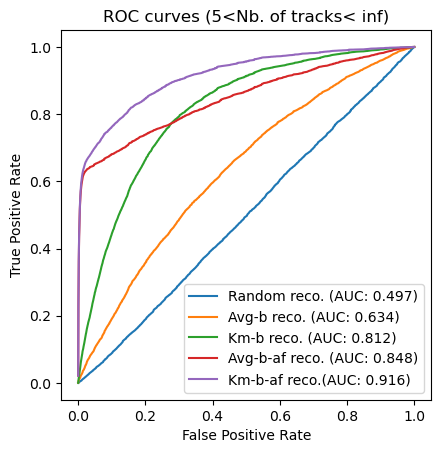

In [34]:
plt.plot(rand_fpr_avg, rand_tpr_avg, label = f'Random reco. (AUC: {round(rand_auc,3)})')
plt.plot(avg_fpr_avg, avg_tpr_avg, label = f'Avg-b reco. (AUC: {round(avg_auc,3)})')
plt.plot(kmbr_fpr_avg, kmbr_tpr_avg, label = f'Km-b reco. (AUC: {round(kmbr_auc,3)})')
plt.plot(avg_af_fpr_avg, avg_af_tpr_avg, label = f'Avg-b-af reco. (AUC: {round(avg_af_auc,3)})')
plt.plot(kmbr_af_fpr_avg, kmbr_af_tpr_avg, label = f'Km-b-af reco.(AUC: {round(kmbr_af_auc,3)})')


plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curves ({n_tracks_min}<Nb. of tracks< {n_tracks_max})")
plt.legend()
plt.savefig(FIG_PATH/f'modelisation/evaluation//{seed}/ROC_{n_tracks_min}_{n_tracks_max}.jpg')
plt.show()


In [61]:
rand_user_auc = pd.DataFrame({u : auc(random_perf['fpr'][u], random_perf['tpr'][u]) for u in random_perf['tpr'].keys()},index = ['1'])\
    .melt(var_name = 'user', value_name = 'auc')\
    .merge(wdf_users_summary, on = ['user'])

avg_user_auc = pd.DataFrame({u : auc(avg_perf['fpr'][u], avg_perf['tpr'][u]) for u in avg_perf['tpr'].keys()},index = ['1'])\
    .melt(var_name = 'user', value_name = 'auc')\
    .merge(wdf_users_summary, on = ['user'])

kmbr_user_auc = pd.DataFrame({u : auc(kmbr_perf['fpr'][u], kmbr_perf['tpr'][u]) for u in kmbr_perf['tpr'].keys()},index = ['1'])\
    .melt(var_name = 'user', value_name = 'auc')\
    .merge(wdf_users_summary, on = ['user'])

avg_af_user_auc = pd.DataFrame({u : auc(avg_af_perf['fpr'][u], avg_af_perf['tpr'][u]) for u in avg_af_perf['tpr'].keys()},index = ['1'])\
    .melt(var_name = 'user', value_name = 'auc')\
    .merge(wdf_users_summary, on = ['user'])

kmbr_af_user_auc = pd.DataFrame({u : auc(kmbr_af_perf['fpr'][u], kmbr_af_perf['tpr'][u]) for u in kmbr_af_perf['tpr'].keys()},index = ['1'])\
    .melt(var_name = 'user', value_name = 'auc')\
    .merge(wdf_users_summary, on = ['user'])

In [68]:
rand_user_auc['n_tracks'] = pd.cut(rand_user_auc['track_count'], bins = [0,5,10,15, 20, 25, 30, 40, 50, math.inf])
avg_user_auc['n_tracks'] = pd.cut(avg_user_auc['track_count'], bins = [0,5,10,15, 20, 25, 30, 40, 50,math.inf])
kmbr_user_auc['n_tracks'] = pd.cut(kmbr_user_auc['track_count'], bins = [0,5,10,15, 20, 25, 30, 40, 50,math.inf])
avg_af_user_auc['n_tracks'] = pd.cut(avg_af_user_auc['track_count'], bins =[0,5,10,15, 20, 25, 30, 40, 50,math.inf])
kmbr_af_user_auc['n_tracks'] = pd.cut(kmbr_af_user_auc['track_count'], bins = [0,5,10,15, 20, 25, 30, 40, 50,math.inf])


In [69]:
rand_user_auc['method'] = 'rand'
avg_user_auc['method'] = 'avg-b'
kmbr_user_auc['method'] = 'kmbr-b' 
avg_af_user_auc['method'] = 'avg-b af'
kmbr_af_user_auc['method'] = 'kmb-b af'

In [70]:
user_auc = pd.concat([rand_user_auc, avg_user_auc, kmbr_user_auc, avg_af_user_auc, kmbr_af_user_auc])

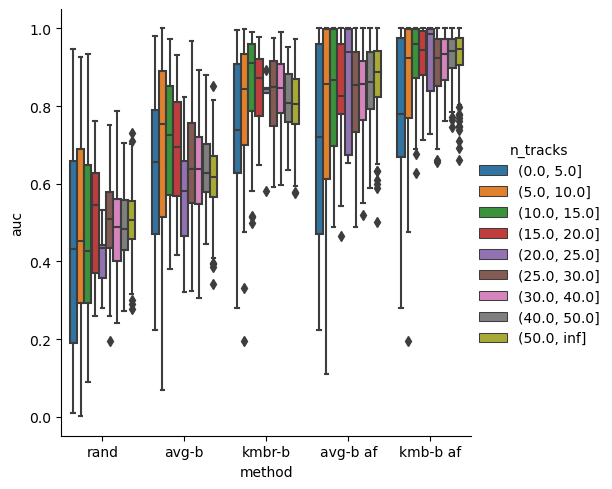

In [73]:
sns.catplot(y = 'auc', x = 'method', data = user_auc, hue = 'n_tracks', kind = 'box')
# plt.scatter(avg_user_auc.track_count, avg_user_auc.auc, label = f'Random reco.')
# plt.scatter(kmbr_user_auc.track_count, kmbr_user_auc.auc, label = f'Random reco.')
# plt.scatter(avg_af_user_auc.track_count, avg_af_user_auc.auc, label = f'Random reco.')
# plt.scatter(kmbr_af_user_auc.track_count, kmbr_af_user_auc.auc, label = f'Random reco.')


In [28]:
kmbr_af_ranking[list(kmbr_af_ranking.keys())[0]]

,artist_name,track_id,0,1,min_centroids,artist_rank,best_rank
track_id,,,,,,,
Banana Co - Radiohead,Radiohead,Banana Co - Radiohead,11503.0,287.0,287.0,1.0,1.0
Karma Police - Radiohead,Radiohead,Karma Police - Radiohead,6738.0,428.0,428.0,2.0,2.0
Talk Show Host - Radiohead,Radiohead,Talk Show Host - Radiohead,10781.0,550.0,550.0,3.0,3.0
(Nice Dream) - Radiohead,Radiohead,(Nice Dream) - Radiohead,4829.0,876.0,876.0,4.0,4.0
Punchdrunk Lovesick Singalong - Radiohead,Radiohead,Punchdrunk Lovesick Singalong - Radiohead,18544.0,1195.0,1195.0,5.0,5.0
...,...,...,...,...,...,...,...
Instructions Interlude - Jermaine Dupri,Jermaine Dupri,Instructions Interlude - Jermaine Dupri,27522.0,27493.0,27493.0,27520.0,27493.0
Jaden's Interlude - Will Smith,Will Smith,Jaden's Interlude - Will Smith,27497.0,27524.0,27497.0,27521.0,27497.0
40 Break - Brotha Lynch Hung,Brotha Lynch Hung,40 Break - Brotha Lynch Hung,27505.0,27507.0,27505.0,27522.0,27505.0
